In [1]:
from pathlib import Path

import os
import sys

current_path = Path(os.getcwd())
sys.path.append(str(current_path))

In [2]:
import vectorian
vectorian.compile()

Matching checksum for /Users/arbeit/Projects/vectorian-2021/vectorian/core/cpp/core.cpp --> not compiling


In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
import vectorian
from vectorian.embeddings import FastText

fasttext = FastText("en")

In [5]:
import vectorian.utils as utils

token_mappings = {
    "tokenizer": [],
    "tagger": []
}

token_mappings["tokenizer"].append(utils.lowercase())
token_mappings["tokenizer"].append(utils.erase("W"))
token_mappings["tokenizer"].append(utils.alpha())

def filter_punct(t):
    return None if t["pos"] == "PUNCT" else t

token_mappings["tagger"].append(filter_punct)
token_mappings["tagger"].append(utils.rewrite({
    'pos': {
        'PROPN': 'NOUN'
    },
    'tag': {
        'NNP': 'NN',
        'NNPS': 'NNS',
    }
}))



In [6]:
from vectorian.importers import StringImporter
from vectorian.session import LabSession
from vectorian.metrics import CosineMetric, TokenSimilarityMetric
from vectorian.metrics import AlignmentSentenceMetric
from vectorian.alignment import WatermanSmithBeyer

im = StringImporter(nlp)
doc = im("Hey, ye want to talk like a pirate, eh?")

metric = AlignmentSentenceMetric(
    token_metric=TokenSimilarityMetric(fasttext, CosineMetric()),
    alignment=WatermanSmithBeyer())

session = LabSession(
    [doc],
    static_embeddings=[fasttext],
    token_mappings=token_mappings)

index = session.partition("sentence").index(metric, nlp)

Importing <string>: 100%|██████████| 1/1 [00:00<00:00, 59.21it/s]


In [7]:
index.describe()

metric:
  alignment:
    algorithm: wsb
    gap: !!python/object/apply:numpy.core.multiarray._reconstruct
      args:
      - !!python/name:numpy.ndarray ''
      - !!python/tuple
        - 0
      - !!binary |
        Yg==
      state: !!python/tuple
      - 1
      - !!python/tuple
        - 9
      - !!python/object/apply:numpy.dtype
        args:
        - f4
        - false
        - true
        state: !!python/tuple
        - 3
        - <
        - null
        - null
        - null
        - -1
        - -1
        - 0
      - false
      - !!binary |
        AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
    zero: 0.5
  metric: alignment-isolated
  token_metric:
    embedding: fasttext-en
    metric: cosine
    name: fasttext-en-cosine
    options: {}
partition:
  level: sentence
  window_size: 1
  window_step: 1



In [6]:
session.documents

In [7]:
def debug(args):
    if args["hook"] == "sim_matrix":
        print(args["matrix"].shape)

In [8]:
r = index.find("speak", n=1, debug=debug)
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

(10, 1)


In [9]:
r.annotate("metadata")

In [10]:
r.annotate("flow")

In [11]:
r[0].doc_span 

KeyError: 'style'

In [14]:
r[0].doc_span[0]

In [15]:
r[0].query[0]

In [9]:
r.to_json()

[{'document': {'version': '1.0',
   'unique_id': '2021-03-08 13:08:50.543991',
   'origin': '<string>',
   'author': '',
   'title': '',
   'speakers': {}},
  'slice': 0,
  'location': {'token_at': 0, 'n_tokens': 9},
  'score': 0.601454496383667,
  'metric': 'fasttext-en',
  'regions': [{'s': 'Hey, ye want to ', 'gap_penalty': 0.0},
   {'s': 'talk',
    't': 'speak',
    'similarity': 0.601454496383667,
    'weight': 1.0,
    'pos_s': 'VERB',
    'pos_t': 'VERB',
    'metric': 'fasttext-en'},
   {'s': 'like a pirate, eh', 'gap_penalty': 0.0}],
  'omitted': [],
  'level': 'word'}]

In [8]:
session.get_embedding_instance(fasttext).tok2vec("talk").shape

(300,)

In [12]:
import numpy as np
tok2vec = session.get_embedding_instance(fasttext).tok2vec
np.dot(tok2vec("talk"), tok2vec("speak"))

0.60145444

In [16]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession
from vectorian.metrics import CosineMetric, TokenSimilarityMetric
from vectorian.metrics import AlignmentSentenceMetric
from vectorian.alignment import WatermanSmithBeyer

im = NovelImporter(nlp)
doc = im("/Users/arbeit/Wise Children.txt")

session = LabSession(
    [doc],
    [fasttext],
    token_mappings)

index = session.partition("sentence").index(metric, nlp)

Importing /Users/arbeit/Wise Children.txt: 100%|██████████| 369/369 [00:04<00:00, 77.90it/s] 


In [19]:
r = index.find("write female", n=3)  # options={'pos_filter': ["NOUN"]}

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [20]:
r.duration

0.036850929260253906

In [21]:
r

In [16]:
r.annotate("tags")

In [18]:
index = session.partition("token", 15, 1).index(metric, nlp)
index.find("write female", n=3)

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [17]:
from vectorian.metrics import CosineMetric, TokenSimilarityMetric, AlignmentSentenceMetric
from vectorian.alignment import WordMoversDistance

index = session.partition("sentence").index(AlignmentSentenceMetric(
    token_metric=TokenSimilarityMetric(fasttext, CosineMetric()),
    alignment=WordMoversDistance()), nlp=nlp)

#query = nlp("making america great again")
r = index.find("the great star", n=5, min_score=0.1)

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [18]:
index.describe()

metric:
  alignment:
    algorithm: rwmd
    normalize_bow: false
    one_target: true
    symmetric: false
  metric: alignment-isolated
  token_metric:
    embedding: fasttext-en
    metric: cosine
    name: fasttext-en-cosine
    options: {}
partition:
  level: sentence
  window_size: 1
  window_step: 1



In [19]:
r

In [29]:
r[0].flow

{'type': 'sparse',
 'source': array([0, 0, 2, 2, 1, 1], dtype=int16),
 'target': array([ 4, 17, 24, 24,  5,  5], dtype=int16),
 'weight': array([1., 1., 1., 1., 1., 1.], dtype=float32)}

In [30]:
def debug_flow(match):
    flow = match.flow
    
    s_span = match.doc_span
    t_span = match.query
    
    for t, s, w in zip(flow['source'], flow['target'], flow['weight']):
        print(t_span[t].text, f"[{t}]", "->", s_span[s].text, f"[{s}]", ": ", w)
    

In [31]:
debug_flow(r[1])

the [0] -> the [13] :  1.0
star [2] -> actor [4] :  0.44881058
star [2] -> Great [14] :  1.0
great [1] -> Great [14] :  1.0


In [28]:
r[0].span[17].text

'the'

In [14]:
r.annotate()

In [6]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession
from vectorian.metrics import CosineMetric, TokenSimilarityMetric
from vectorian.metrics import AlignmentSentenceMetric
from vectorian.alignment import WatermanSmithBeyer

im = NovelImporter(nlp)
doc = im("/Users/arbeit/Wise Children.txt")

session = LabSession(
    [doc],
    [fasttext],
    token_mappings)

Importing /Users/arbeit/Wise Children.txt: 100%|██████████| 369/369 [00:04<00:00, 83.86it/s] 


In [31]:
import tabulate

from vectorian.metrics import CosineMetric, TokenSimilarityMetric, AlignmentSentenceMetric
from vectorian.alignment import WordRotatorsDistance

wrd_metric = AlignmentSentenceMetric(
    word_metric=TokenSimilarityMetric(fasttext, CosineMetric()),
    alignment=WordRotatorsDistance())
index = session.partition("sentence").index(wrd_metric, nlp)

debug_data = []
def debug_hook(args):
    if args["hook"] == "sim_matrix":
        print(args["matrix"].shape)
    if args["hook"] == "alignment_wrd":
        data = args["data"]
        # numpy arrays might be mapped, copy them for later processing.
        debug_data.append({
            's': data['s'],
            't': data['t'],
            'mag_s': data['mag_s'].copy(),
            'mag_t': data['mag_t'].copy(),
            'D': data['D'].copy(),
            'type': data['solution']['type'],
            'G': data['solution']['G']})

r = index.find("they were not alike as two peas", n=5, min_score=0.1, debug=debug_hook)

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

(3732, 7)


In [32]:
r

In [ ]:
with open("/Users/arbeit/Desktop/debug.txt", "w") as f:
    def write_table(name, data):
        f.write("\n")
        f.write(name + ":\n")
        table = [[""] + x["t"]["text"]]
        for i in range(len(x["s"]["text"])):
            row = [x["s"]["text"][i]]
            for j in range(len(x["t"]["text"])):
                row.append("%.2f" % data[i, j])
            table.append(row)
        f.write(tabulate.tabulate(table) + "\n")

    def write_vec(name, tokens, values):
        f.write("\n")
        f.write(name + ":\n")
        table = []
        for t, x in zip(tokens["text"], values):
            table.append([t, x])
        f.write(tabulate.tabulate(table) + "\n")

    for x in debug_data:
        f.write("# " + x["type"] + "\n")
        f.write("s: " + " ".join(x["s"]["text"]) + " " + str(x["s"]["id"]) + " (" + str(len(x["s"]["text"])) + ")\n")
        f.write("t: " + " ".join(x["t"]["text"]) + " " + str(x["t"]["id"]) + " (" + str(len(x["t"]["text"])) + ")\n")
        write_vec("mag_s", x["s"], x["mag_s"])
        write_vec("mag_t", x["t"], x["mag_t"])
        write_table("D", x["D"])
        write_table("G", x["G"])
        f.write("\n\n")

In [8]:
r[0].document.sentence(r[0].sentence)

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 5,
 'token_at': 25,
 'n_tokens': 83}

In [9]:
start = r[0].document.tokens["idx"][25]
end = r[0].document.tokens["idx"][25 + 83]
r[0].document.substr(start, end)

'THERE was once a child, and he strolled about a good deal, and thought of a number of things. He had a sister, who was a child too, and his constant companion. These two used to wonder all day long. They wondered at the beauty of the flowers; they wondered at the height and blueness of the sky; they wondered at the depth of the bright water; they wondered at the goodness and the power of God, who made the lovely world.\n\n'

In [6]:
from vectorian.embeddings import Glove
glove = Glove()

session = LabSession(
    [doc],
    [fasttext, glove])

In [7]:
from vectorian.metrics import CosineMetric, LerpMetric, PNormMetric

query = nlp("play")

#r = session.find(query, n=3, metric=PNormMetric(fasttext, p=2, scale=0.1))
r = session.find(query, n=3)

#r = session.find(query, n=3, metric=LerpMetric(
#    CosineMetric(fasttext),
#    CosineMetric(glove),
#    0.8))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [10]:
r.duration

0.024589061737060547

In [11]:
r

In [6]:
session = LabSession(
    [doc],
    [glove])

100%|██████████| 58/58 [00:00<00:00, 114.64it/s]


In [11]:
query = nlp("short")
r = session.find(query, n=3)
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

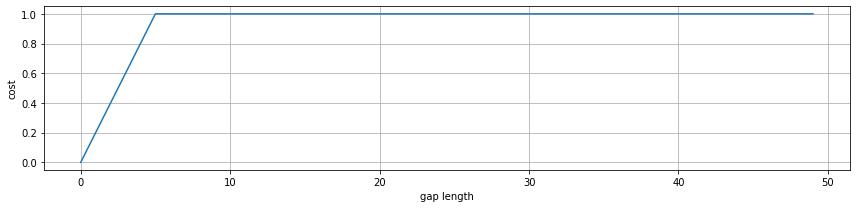

In [1]:
from vectorian.alignment import LinearGapCost, WatermanSmithBeyer

LinearGapCost(0.2)

In [3]:
#session.exponential_gap_costs(5)  # , 20)session.max_sentence_len

waterman_smith_beyer(gap=0.2, zero=0.5)

{'algorithm': 'wsb', 'gap': array([0.2], dtype=float32), 'zero': 0.5}

In [5]:
r = session.find(query, n=3, options={
    'alignment': WatermanSmithBeyer(gap=LinearGapCost(0.2), zero=0.5)
})

True

In [3]:
current_path

PosixPath('/Users/arbeit/Projects/vectorian-2021')

# Query Details Example

In [12]:
r[0].query.text

'play'

In [13]:
len(r[0].document.text)

6457

In [14]:
r[0].document.tokens

{'id': array([ 0,  1,  2, ...,  6,  6, -1], dtype=int32),
 'idx': array([   0,    2,    7, ..., 6568, 6570, 6571], dtype=int32),
 'len': array([1, 5, 4, ..., 2, 1, 0], dtype=int8),
 'pos': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8),
 'tag': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8)}

In [16]:
r[0].assignment

{'idx': array([66], dtype=int16),
 'sim': array([0.7944386], dtype=float32),
 'w': array([1.], dtype=float32)}

In [17]:
sent = r[0].document.sentence(r[0].sentence)
sent

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 8,
 'token_at': 110,
 'n_tokens': 101}

In [20]:
index = r[0].assignment["idx"][0] + sent["token_at"]
start = r[0].document.tokens["idx"][index]
end = start + r[0].document.tokens["len"][index]
print("match with: ", r[0].document.substr(start, end))
print("sim: ", r[0].assignment["sim"][0])

match with:  playing
sim:  0.7944386


In [13]:
doc

In [8]:
doc.save("/Users/arbeit/Desktop/doc.json")

In [12]:
print(doc.structure)

partition 1:
  sentence 1:
    A Child’s Dream Of A Star.
  sentence 2:
    


partition 2:
  sentence 1:
    


partition 3:
  sentence 1:
    


partition 4:
  sentence 1:
    A CHILD’S DREAM OF A STAR.
  sentence 2:
    


partition 5:
  sentence 1:
    
Short Stories Table of Contents.
  sentence 2:
    


partition 6:
  sentence 1:
    THERE was once a child, and he strolled about a good deal, and thought of a number of things.
  sentence 2:
    He had a sister, who was a child too, and his constant companion.
  sentence 3:
    These two used to wonder all day long.
  sentence 4:
    They wondered at the beauty of the flowers; they wondered at the height and blueness of the sky; they wondered at the depth of the bright water; they wondered at the goodness and the power of God, who made the lovely world.
  sentence 5:
    


partition 7:
  sentence 1:
    


partition 8:
  sentence 1:
    


partition 9:
  sentence 1:
    They used to say to one another, sometimes,
  sentence 2:
  

# Interactive GUI

In [11]:
query = nlp("large")
r = session.find(query, n=3, options={'tag_weights': {
    'JJ': 0.8
}})
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

# Sentence Embeddings

In [1]:
from pathlib import Path

import os
import sys

current_path = Path(os.getcwd())
sys.path.append(str(current_path))

import vectorian

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [18]:
type(model)

sentence_transformers.SentenceTransformer.SentenceTransformer

In [3]:
from vectorian.metrics import SentenceEmbeddingMetric
metric = SentenceEmbeddingMetric(model.encode)

Matching checksum for /Users/arbeit/Projects/vectorian-2021/vectorian/core/cpp/core.cpp --> not compiling


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
from vectorian.importers import StringImporter
from vectorian.session import LabSession

im = StringImporter(nlp)
docs = [im(x) for x in [
    "Hey, ye want to talk like a pirate, eh?",
    "Summer strolls are beautiful."]]

session = LabSession(docs)
index = session.partition("sentence").index(metric)

Encoding: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


In [6]:
#docs[0].to_json()

In [8]:
index.find("sea")

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [6]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession

im = NovelImporter(nlp)
doc = im("/Users/arbeit/Wise Children.txt")
session = LabSession([doc])

Importing /Users/arbeit/Wise Children.txt: 100%|██████████| 369/369 [00:05<00:00, 67.84it/s] 


In [ ]:
index = session.partition("sentence", 2).index(metric)

In [10]:
doc.save("/Users/arbeit/Desktop/novel.json")

In [9]:
index.save(Path("/Users/arbeit/Desktop/my_index"))

Saving: 100%|██████████| 1/1 [00:00<00:00, 104.80it/s]


In [7]:
index = metric.load_index(session, "/Users/arbeit/Desktop/my_index")

In [14]:
session.documents[0].tokens['len'][386]

0

In [10]:
#index.find("two and four")
#index.find("making America great again")
index.find("under the greenwood tree")

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [6]:
from vectorian.importers import ShakespeareImporter
from vectorian.session import LabSession

im = ShakespeareImporter(nlp)
doc = im("/Users/arbeit/Desktop/play.xml")
session = LabSession(
    [doc],
    static_embeddings=[fasttext],
    token_mappings=token_mappings)

Importing /Users/arbeit/Desktop/play.xml: 100%|██████████| 916/916 [00:07<00:00, 128.00it/s]


In [7]:
index = session.index_for_metric()

In [8]:
index.find(nlp("girl"))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [14]:
doc._json["metadata"]

{'version': '1.0',
 'unique_id': 'William Shakespeare/All’s Well That Ends Well',
 'origin': PosixPath('/Users/arbeit/Desktop/play.xml'),
 'author': 'William Shakespeare',
 'title': 'All’s Well That Ends Well',
 'speakers': {1: 'Countess of Roussillon',
  2: 'Bertram, Count of Roussillon',
  3: 'Lafew',
  4: 'Helena',
  5: 'Parolles',
  6: 'Countess’s Page',
  7: 'King of France',
  8: 'First French Lord Dumaine',
  9: 'Second French Lord Dumaine',
  10: 'Rinaldo',
  11: 'Lavatch',
  12: 'Both French Lords',
  13: 'All French Lords',
  14: 'First French Lord',
  15: 'Second French Lord',
  16: 'Fourth French Lord',
  17: 'Duke of Florence',
  18: 'An Old Widow of Florence',
  19: 'Diana',
  20: 'Mariana',
  21: 'Both Mariana and Widow',
  22: 'First Soldier as Interpreter',
  23: 'Second Soldier',
  24: 'Messenger',
  25: 'Gentleman'}}

In [22]:
from IPython.core.display import display, HTML
display(HTML('<span style="background:lightgray; border-radius:0.25em;">Hello, world!</span> <span style="border: 2px solid;">world!</span>'))

In [15]:
import holoviews as hv
#hv.extension('bokeh')

In [16]:
sankey = hv.Sankey([
    ['A', 'X', 5],
    ['A', 'Y', 7],
    ['A', 'Z', 6],
    ['B', 'X', 2],
    ['B', 'Y', 9],
    ['B', 'Z', 4]]
)
#sankey.opts(width=600, height=400)

type(sankey)

holoviews.element.sankey.Sankey

In [17]:
#type(sankey.opts(width=600, height=400))

In [59]:
p = hv.render(sankey.opts(width=600, height=200), backend='bokeh')
print(type(p))

<class 'bokeh.plotting.figure.Figure'>


In [60]:
p

Figure(id='2227', ...)

In [61]:
import bokeh.plotting
#bokeh.plotting.output_notebook()

import json
import bokeh.embed
# use correct div id here!
item_text = json.dumps(bokeh.embed.json_item(p, "bokeh_ch1"))

In [62]:
from IPython.core.display import HTML
import html
import string

x_html = string.Template('''
<html>
<head>
<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
<script src="https://cdn.bokeh.org/bokeh/release/bokeh-${bokeh_version}.min.js"
        crossorigin="anonymous"></script>
<script src="https://cdn.bokeh.org/bokeh/release/bokeh-widgets-${bokeh_version}.min.js"
        crossorigin="anonymous"></script>
<script src="https://cdn.bokeh.org/bokeh/release/bokeh-tables-${bokeh_version}.min.js"
        crossorigin="anonymous"></script>
</head>
<body>

    some div: <div id="bokeh_ch1"></div>
    bla.

<script>

/* $('#bokeh_ch1').text("hi"); */

$('#bokeh_ch1').ready(function () {
    item = JSON.parse('$item_text');
    Bokeh.embed.embed_item(item);
});

/*    console.log("hello1");


*/

</script>

</body>
</html>
''').safe_substitute(
    item_text=item_text,
    bokeh_version=bokeh.__version__)

HTML(f'''
<iframe id="my_iframe"
width=800
height=400
srcdoc="{html.escape(x_html)}"
>
''')


'2.3.0'